In [75]:
from feast import FeatureStore
from feast.infra.offline_stores.file_source import SavedDatasetFileStorage

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 


store= FeatureStore(repo_path=r"../feature_store/")

## Model Training

In [76]:
dataset = store.get_saved_dataset('training_dataset')
training_df = dataset.to_df()

F:\Production\feast_feature_Store_integration_template\env\lib\site-packages\feast\feature_store.py:1235: RuntimeWarning: Retrieving datasets is an experimental feature. This API is unstable and it could and most probably will be changed in the future. We do not guarantee that future changes will maintain backward compatibility.
  warnings.warn(


In [77]:
training_df.head()

,no_of_employees,education_of_employee,continent_Africa,unit_of_wage_Hour,region_of_employment_South,unit_of_wage_Month,continent_North America,region_of_employment_Island,region_of_employment_West,full_time_position,...,has_job_experience,event_timestamp,continent_Europe,continent_Oceania,continent_South America,unit_of_wage_Week,region_of_employment_Midwest,case_id,company_age,requires_job_training
0,1.517300,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1953-02-19 15:20:53.084144+00:00,0.0,0.0,0.0,0.0,0.0,EZYV01,-0.943712,0.0
1,0.030912,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1953-02-20 15:20:53.084144+00:00,0.0,0.0,0.0,0.0,0.0,EZYV02,-0.454005,0.0
2,2.885076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1953-02-21 15:20:53.084144+00:00,0.0,0.0,0.0,0.0,0.0,EZYV03,-1.069026,1.0
3,-1.343550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1953-02-22 15:20:53.084144+00:00,0.0,0.0,0.0,0.0,0.0,EZYV04,1.625983,0.0
4,-0.432287,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1953-02-23 15:20:53.084144+00:00,0.0,0.0,0.0,0.0,0.0,EZYV05,-0.724210,0.0


In [78]:
labels = training_df['case_status']
labels= np.where(labels=='Denied', 1,0)
labels

array([1, 0, 1, ..., 0, 0, 0])

In [79]:
features = training_df.drop(
    labels=['case_status', 'event_timestamp', "case_id"], 
    axis=1)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    random_state=42)

In [82]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [83]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [84]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X_train, X_test, y_train, y_test, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
#     X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        
        model = list(models.values())[i]
        
        model.fit(X_train, y_train) 

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall, model_train_rocauc_score = evaluate_clf(y_train , y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

In [85]:
base_model_report =evaluate_models(X_train, X_test, y_train, y_test, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.7248
- F1 score: 0.5304
- Precision: 0.6096
- Recall: 0.4694
- Roc Auc Score: 0.6603


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.6644
- F1 score: 0.4984
- Precision: 0.4933
- Recall: 0.5036
- Roc Auc Score: 0.6238


Gradient Boosting
Model performance for Training set
- Accuracy: 0.7532
- F1 score: 0.5800
- Precision: 0.6679
- Recall: 0.5125
- Roc Auc Score: 0.6928
----------------------------------
Model performance for Test set
- Accuracy: 0.7542
- F1 score: 0.5745
- Precision: 0.6728
- Recall: 0.5012
- Roc Auc Score: 0.6903


Logistic Regression
Model performance for Training 

## Final Model

In [99]:
best_model = KNeighborsClassifier(n_neighbors= 30,weights= 'distance',algorithm= 'auto')
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL
Accuracy Score value: 0.7339
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      4261
           1       0.65      0.43      0.51      2109

    accuracy                           0.73      6370
   macro avg       0.70      0.66      0.67      6370
weighted avg       0.72      0.73      0.72      6370



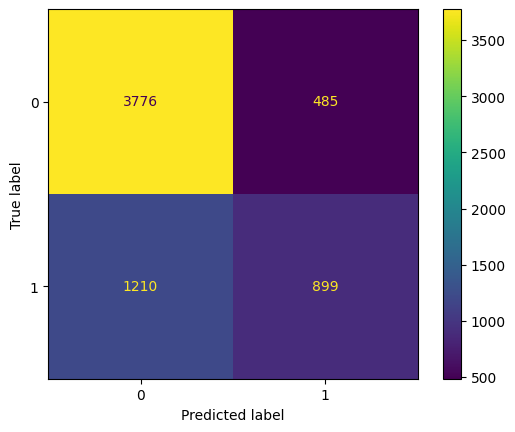

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)